## Project 2
## Γιάννης Δαλιάνης 1115201700027
## Μιχαλης Φωτιάδης 1115201700183

## Ερώτημα 1

Imports

In [1]:
import os
import re
from os import listdir
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.cluster import KMeansClusterer
from nltk.tokenize import RegexpTokenizer
import numpy as np
import scipy.spatial
from collections import Counter
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn import naive_bayes
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, normalize, LabelBinarizer, label_binarize, MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
import seaborn as sns
sns.set()
from gensim.models import Word2Vec
from scipy import sparse
import string

import warnings
warnings.filterwarnings("ignore")

Dataframe of all articles. Article "./data/sport/199.txt" is discarded due to encoding Errors.

In [2]:
files_to_avoid = [".ipynb_checkpoints", "README.TXT"]

titles = list()
content_list = list()
id_list = list()
categories = list()
count = 0

for filename in os.listdir("./data"):
    pth = "./data"
    if filename not in files_to_avoid:
        if os.path.isdir(pth + '/' + filename):
            pth = pth + '/' + filename
            for in_file in os.listdir(pth):
                if in_file not in files_to_avoid:
                    in_file = pth + '/' + in_file
                    if(in_file!="./data/sport/199.txt"):
                        with open(in_file, 'rb') as f:
                            contents = f.read()
                            contents = contents.decode("utf-8")
                            splitter = contents.split('\n\n', 1)
                            title = splitter[0]
                            content  = splitter[1]

                            title = title.replace("\n", "")
                            title = title.replace("\\", "")

                            content = content.replace("\n", "")
                            content = content.replace("\\", "")

                            titles.append(title)
                            content_list.append(content)
                            categories.append(filename)

                            id_list.append(count)
                            count += 1

data = {
    'Id': id_list,
    'Title': titles,
    'Content': content_list,
    'Category':categories
}

converter = dict(zip(list(set(categories)), [i+1 for i in range(len(list(set(categories))))] ))

df = pd.DataFrame (data)
df["Label"] = df["Category"].map(converter)

df['Content'].dropna(inplace=True)

df.dropna(inplace=True)
df['Content'] = [entry.lower() for entry in df['Content']]

print(df.isna().sum()) # are there null cells?
print(df.head())
print(df.tail())
print(df.isnull().values.any()) # if False there are no NULL values
df

Id          0
Title       0
Content     0
Category    0
Label       0
dtype: int64
   Id                              Title  \
0   0  Ad sales boost Time Warner profit   
1   1   Dollar gains on Greenspan speech   
2   2  Yukos unit buyer faces loan claim   
3   3  High fuel prices hit BA's profits   
4   4  Pernod takeover talk lifts Domecq   

                                             Content  Category  Label  
0  quarterly profits at us media giant timewarner...  business      1  
1  the dollar has hit its highest level against t...  business      1  
2  the owners of embattled russian oil giant yuko...  business      1  
3  british airways has blamed high fuel prices fo...  business      1  
4  shares in uk drinks and food firm allied domec...  business      1  
        Id                             Title  \
2219  2219  BT program to beat dialler scams   
2220  2220   Spam e-mails tempt net shoppers   
2221  2221           Be careful how you code   
2222  2222   US cyber securi

Id                              Title  \
0        0  Ad sales boost Time Warner profit   
1        1   Dollar gains on Greenspan speech   
2        2  Yukos unit buyer faces loan claim   
3        3  High fuel prices hit BA's profits   
4        4  Pernod takeover talk lifts Domecq   
...    ...                                ...   
2219  2219   BT program to beat dialler scams   
2220  2220    Spam e-mails tempt net shoppers   
2221  2221            Be careful how you code   
2222  2222    US cyber security chief resigns   
2223  2223   Losing yourself in online gaming   

                                                Content  Category  Label  
0     quarterly profits at us media giant timewarner...  business      1  
1     the dollar has hit its highest level against t...  business      1  
2     the owners of embattled russian oil giant yuko...  business      1  
3     british airways has blamed high fuel prices fo...  business      1  
4     shares in uk drinks and food firm allied domec...  business      1  
...                                                 ...       ...    ...  
2219  bt is introducing two initiatives to help beat...      tech      4  
2220  computer users across the world continue to ig...      tech      4  
2221  a new european directive could put software wr...      tech      4  
2222  the man making sure us computer networks are s...      tech      4  
2223  online role playing games are time-consuming, ...      tech      4  

[2224 rows x 5 columns]

Make the two .tsv files.

In [3]:
text = df["Content"]
Labels = df['Label']

Train_X, Test_X, Train_Y, Test_Y = train_test_split(text, Labels, test_size=0.2)

Train_X.to_csv('train.tsv',sep='\t', index=False)
Test_X = Test_X.drop(columns=['Category'])
Test_X.to_csv('test.tsv', sep='\t', index=False)

Make word clouds for all the categories.

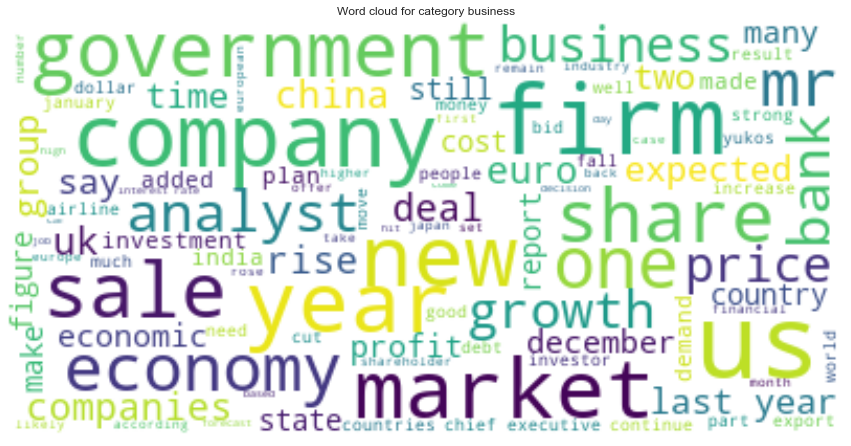

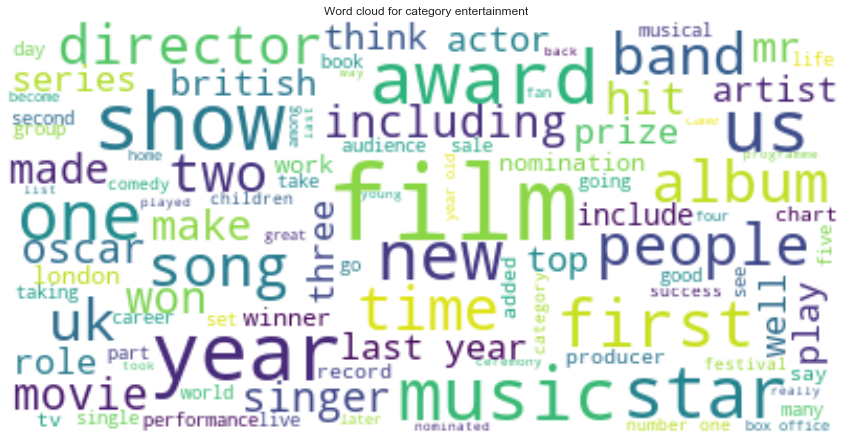

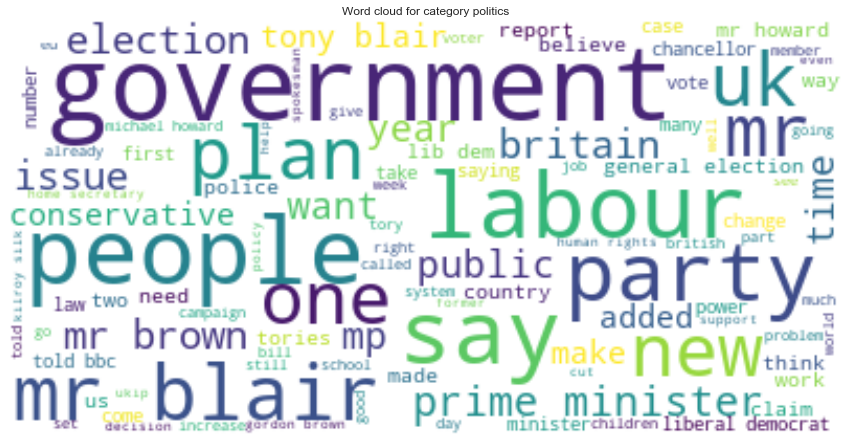

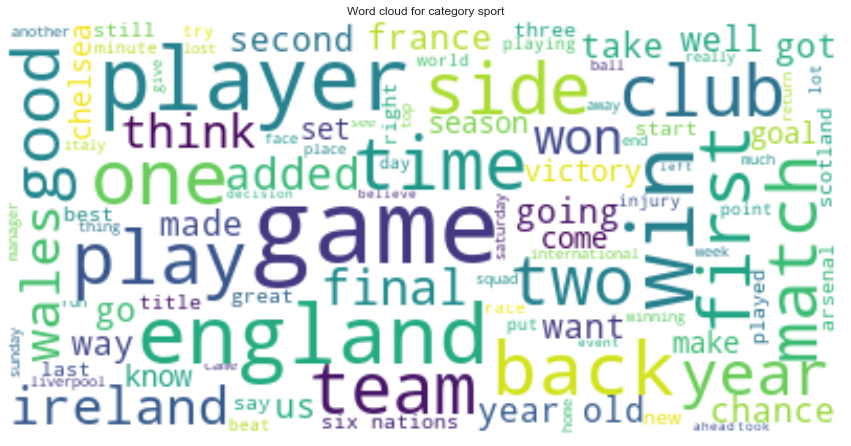

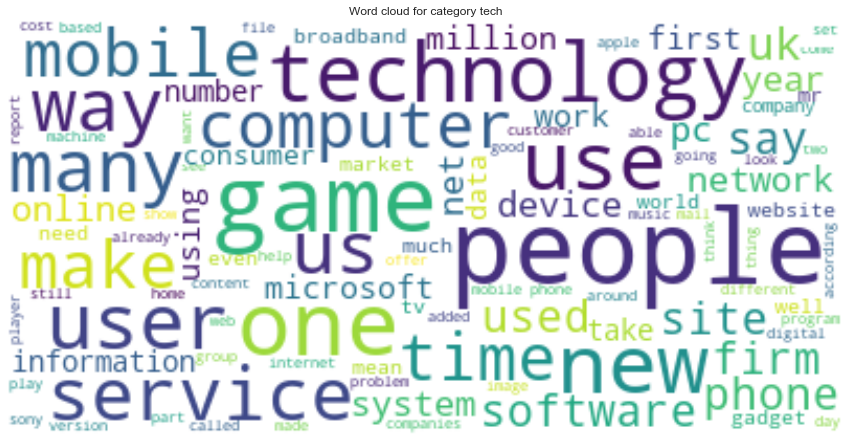

In [4]:
all_categories = list(df["Category"].unique())

stopwords = set(STOPWORDS)
stopwords.update(["said", "now", "may", "is", "the", "will"])

for i in all_categories:
    text = df.loc[df['Category'] == i]["Content"]
    wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))

    plt.figure(figsize=[15,10])
    plt.title('Word cloud for category ' + str(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Ερώτημα 2

BoW και tf-idf αναπαραστάσεις των κειμένων.

Εncode labels.

In [5]:
Test_Y_Random_Forests = Test_Y

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf vectorizer

In [6]:
Tfidf_vect = TfidfVectorizer(min_df = 5, max_df = 0.95, max_features = 8000, stop_words = 'english')

Tfidf_vect.fit(text)

ContentFit = Tfidf_vect.transform(text)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

Count vectorizer

In [7]:
train_to_list = np.array(Train_X.values.tolist())

BoWvect = CountVectorizer()
bow_xtrain = BoWvect.fit_transform(train_to_list)
bow_xtest = BoWvect.transform(Test_X)

SVM function.

In [8]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average, multi_class='ovo')

def multiclass_roc_auc_score2(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return roc_auc_score(y_test, y_pred.reshape(-1, 1), average=average, multi_class='ovo')

def ScoringFunc(estim, trainX, trainY, testX, testY):
    scoring = {
       'accuracy' : make_scorer(accuracy_score), 
       'precision' : make_scorer(precision_score, average='macro'),
       'recall' : make_scorer(recall_score, average='macro'), 
       'f1_score' : make_scorer(f1_score, average='macro')
    }
    kfold = KFold(n_splits=10)#, random_state=42)
    results = cross_validate(estimator=estim,
                                          X=trainX,
                                          y=trainY,
                                          cv=kfold,
                                          scoring=scoring,
                                          return_train_score=True
                        )
    sorted(results.keys())
    print("\n10-fold Cross Validation Score:")
    for i in results:
        print(i , results[i], "\n")

    trainX = trainX.toarray()
    trainy = trainY
    testX = testX.toarray()
    testy = Test_Y

    ns_probs = [0 for _ in range(len(testy))]

    model = estim
    model.fit(trainX, trainy)
    lr_probs = model.predict_proba(testX)
    lr_probs = lr_probs[:, 1]

    ns_auc = multiclass_roc_auc_score(testy, ns_probs, average="macro")
    lr_auc = multiclass_roc_auc_score2(testy, lr_probs, average="macro")

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

def SVMex(trainX, trainY, testX, testY, Labels):
    SVM = SVC(C=1.0, kernel='linear', degree=3, gamma=0.1, probability=True)
    SVM.fit(trainX, trainY)

    predictions_SVM = SVM.predict(testX)
    
    print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, testY)*100)
    print("SVM Recall Score -> ",recall_score(predictions_SVM, testY, average='macro')*100)
    print("SVM Precision Score -> ",precision_score(predictions_SVM, testY, average='macro')*100)
    print("SVM F-Measure Score -> ",f1_score(predictions_SVM, testY, average='macro')*100)
#     print(classification_report(testY,predictions_SVM))
    
    scores = cross_val_score(SVM, trainX, trainY, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    ScoringFunc(SVM, trainX, trainY, testX, testY)

SVM on Tfidf.

In [9]:
SVMex(Train_X_Tfidf, Train_Y, Test_X_Tfidf, Test_Y, Labels)

SVM Accuracy Score ->  96.17977528089887
SVM Recall Score ->  96.37041098038894
SVM Precision Score ->  96.19694813530919
SVM F-Measure Score ->  96.27292334971128
Accuracy: 0.96 (+/- 0.02)

10-fold Cross Validation Score:
fit_time [7.11856294 6.98923588 7.03800964 7.01206446 7.09984946 7.0220232
 7.01039624 7.21142912 7.19690013 7.07151914] 

score_time [0.12469363 0.12203741 0.11790061 0.12082934 0.12332368 0.11516309
 0.12080383 0.11897111 0.11998677 0.11769772] 

test_accuracy [0.9494382  0.97191011 0.96629213 0.97191011 0.96067416 0.96629213
 0.98876404 0.97752809 0.97191011 0.97175141] 

train_accuracy [0.99937539 0.99875078 0.99750156 0.99875078 0.99875078 0.99812617
 0.99875078 0.99875078 0.99750156 0.99937578] 

test_precision [0.9448786  0.97360606 0.96699738 0.97133874 0.96108605 0.96399621
 0.98416149 0.98154825 0.97153338 0.96942641] 

train_precision [0.99933333 0.99861281 0.99733854 0.99877364 0.99876722 0.99788732
 0.99876712 0.99859139 0.99736976 0.99946809] 

test_rec

SVM on BoWvect.

In [10]:
SVMex(bow_xtrain, Train_Y, bow_xtest, Test_Y, Labels)

SVM Accuracy Score ->  95.73033707865169
SVM Recall Score ->  95.76070893208565
SVM Precision Score ->  95.59254644011934
SVM F-Measure Score ->  95.65798757668858
Accuracy: 0.96 (+/- 0.02)

10-fold Cross Validation Score:
fit_time [11.39273667 11.63339186 12.18941712 13.24833417 13.21274686 12.66450477
 12.6888175  12.81372523 12.77718639 12.748106  ] 

score_time [0.23703146 0.24132514 0.24333763 0.23088121 0.28676462 0.25773048
 0.25289869 0.24933648 0.25631452 0.25531864] 

test_accuracy [0.93820225 0.96067416 0.93820225 0.95505618 0.97752809 0.96629213
 0.9494382  0.97752809 0.95505618 0.97740113] 

train_accuracy [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

test_precision [0.93194705 0.95782343 0.938629   0.95423963 0.97730159 0.96222512
 0.94034962 0.97570367 0.95650794 0.97477833] 

train_precision [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

test_recall [0.94024146 0.95465952 0.93603175 0.95749423 0.97758465 0.96413845
 0.945005   0.97804714 0.95354152 0.9795846 ] 

train_recall [1. 1. 1. 1. 1. 1. 

In [11]:
# # https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
def GridSearchFunc(TrainX, TrainY, TestY, TestX):
    # Set the parameters by cross-validation
    tuned_parameters = [
        {'kernel': ['rbf'], 'gamma': [1e-3],'C': [1, 10], 'degree': [3], 'gamma': ['auto']},
        {'kernel': ['linear'], 'C': [1, 10], 'degree': [3], 'gamma': ['auto', 0.1]},
        {'kernel': ['poly'], 'degree': [8]}
    ]

    scores = ['precision', 'recall']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score, "\n")

        clf = GridSearchCV( SVC(), tuned_parameters, scoring='%s_macro' % score )
        clf.fit(TrainX, TrainY)

        print("Best parameters set found on development set:\n")
        print(clf.best_params_)
        print("\nGrid scores on development set:\n")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']

        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

        print("\nDetailed classification report:\n")
        y_true, y_pred = TestY, clf.predict(TestX)
        print(classification_report(y_true, y_pred),"\n")

Use GridSearchCV on Tfidf.

In [12]:
GridSearchFunc(Train_X_Tfidf, Train_Y, Test_Y, Test_X_Tfidf)

# Tuning hyper-parameters for precision 

Best parameters set found on development set:

{'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}

Grid scores on development set:

0.047 (+/-0.000) for {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
0.047 (+/-0.000) for {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
0.964 (+/-0.015) for {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
0.964 (+/-0.015) for {'C': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'linear'}
0.964 (+/-0.018) for {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
0.964 (+/-0.018) for {'C': 10, 'degree': 3, 'gamma': 0.1, 'kernel': 'linear'}
0.855 (+/-0.002) for {'degree': 8, 'kernel': 'poly'}

Detailed classification report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        93
           1       0.99      0.99      0.99        89
           2       0.94      0.96      0.95        97
           3       0.99      0.97      0.9

Use GridSearchCV on BoW.

In [13]:
GridSearchFunc(bow_xtrain, Train_Y, Test_Y, bow_xtest)

# Tuning hyper-parameters for precision 

Best parameters set found on development set:

{'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}

Grid scores on development set:

0.771 (+/-0.070) for {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
0.939 (+/-0.023) for {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
0.958 (+/-0.015) for {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
0.958 (+/-0.015) for {'C': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'linear'}
0.958 (+/-0.015) for {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
0.958 (+/-0.015) for {'C': 10, 'degree': 3, 'gamma': 0.1, 'kernel': 'linear'}
0.690 (+/-0.066) for {'degree': 8, 'kernel': 'poly'}

Detailed classification report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        93
           1       0.97      0.99      0.98        89
           2       0.96      0.97      0.96        97
           3       0.97      0.95      0.96

Random Forests Function.

In [14]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

def RandomF(trainX, trainY, testX, testY):

    rf = RandomForestClassifier(n_estimators=50, bootstrap = True, max_features = 'sqrt')

    rf.fit(trainX, trainY)

    predictions = rf.predict(testX)

    # Probabilities for each class
    rf_probs = rf.predict_proba(testX)[:, 1]
    train_probs = rf.predict_proba(trainX)[:, 1]
    
    # Calculate the absolute errors
    errors = abs(predictions - testY)

    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / Test_Y_Random_Forests)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')
    
    ScoringFunc(rf, trainX, trainY, testX, testY)
    
    fig = plt.figure(figsize=[15,10])
    # Plot the actual values
    plt.plot(testY[:100], 'b-', label = 'actual')
    # Plot the predicted values
    plt.plot(predictions[:100], 'ro', label = 'prediction')
    plt.xticks(rotation = '60'); 
    plt.legend()
    plt.title('Actual and Predicted Values on a sample of 100 Articles.');

Random Forests on Tfidf.

Mean Absolute Error: 0.09 degrees.
Accuracy: 96.79 %.

10-fold Cross Validation Score:
fit_time [0.40391779 0.39993596 0.41885614 0.43882728 0.40852189 0.41891718
 0.42985225 0.40890384 0.40002131 0.40504408] 

score_time [0.0089767  0.00898552 0.01595807 0.00897527 0.00993347 0.009974
 0.00900197 0.00897694 0.01097035 0.00997543] 

test_accuracy [0.89325843 0.93258427 0.96067416 0.91573034 0.94382022 0.9494382
 0.97752809 0.97191011 0.93820225 0.94915254] 

train_accuracy [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

test_precision [0.88513721 0.92768548 0.96055394 0.92565723 0.94590643 0.96032832
 0.97635883 0.97461279 0.94270932 0.94542328] 

train_precision [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

test_recall [0.89178077 0.92342242 0.95638889 0.9120697  0.94467738 0.94435088
 0.97164502 0.96704714 0.93664861 0.94330281] 

train_recall [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

test_f1_score [0.88458998 0.92479252 0.9578154  0.91587213 0.94400093 0.949625
 0.97374265 0.97033488 0.93918538 0.94417755] 

train_f

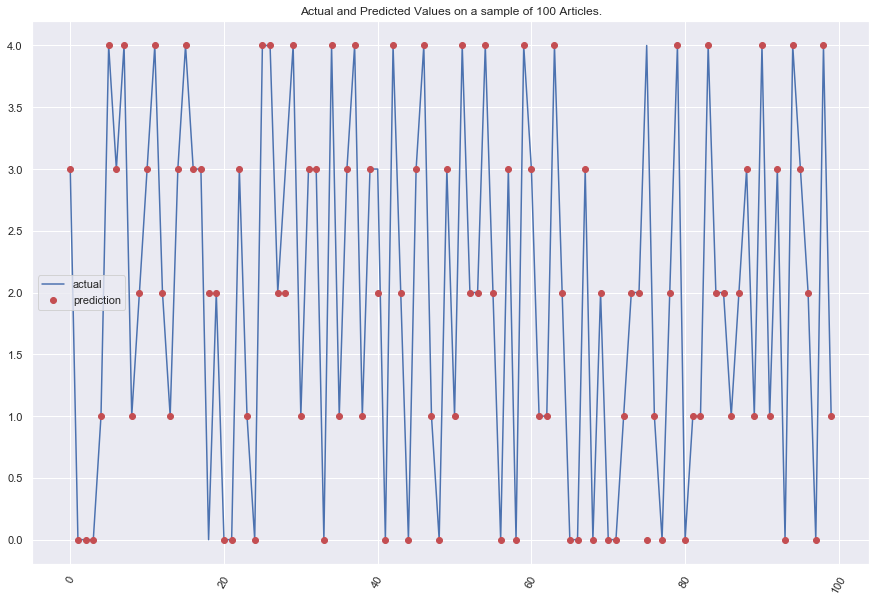

In [15]:
RandomF(Train_X_Tfidf, Train_Y, Test_X_Tfidf, Test_Y)

Random Forests on BoW.

Mean Absolute Error: 0.1 degrees.
Accuracy: 96.73 %.

10-fold Cross Validation Score:
fit_time [0.78734899 0.75025511 0.76123452 0.77227354 0.78646255 0.77831006
 0.77498126 0.77269101 0.75510192 0.7655828 ] 

score_time [0.01597667 0.0139544  0.01595759 0.01595855 0.01398945 0.01795101
 0.01494265 0.01498795 0.01496148 0.01399183] 

test_accuracy [0.8988764  0.92696629 0.9494382  0.92696629 0.93820225 0.95505618
 0.96067416 0.9494382  0.93820225 0.94915254] 

train_accuracy [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

test_precision [0.89204365 0.9330303  0.94959624 0.9388834  0.94035521 0.96442577
 0.96684663 0.95253025 0.94562881 0.95538706] 

train_precision [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

test_recall [0.88614379 0.91810649 0.94746032 0.92409446 0.93859256 0.95235088
 0.9548618  0.94728523 0.93235777 0.94066158] 

train_recall [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

test_f1_score [0.88800003 0.92281243 0.94679724 0.92746009 0.93782097 0.95621847
 0.96008027 0.94931285 0.93716892 0.94680956] 

tra

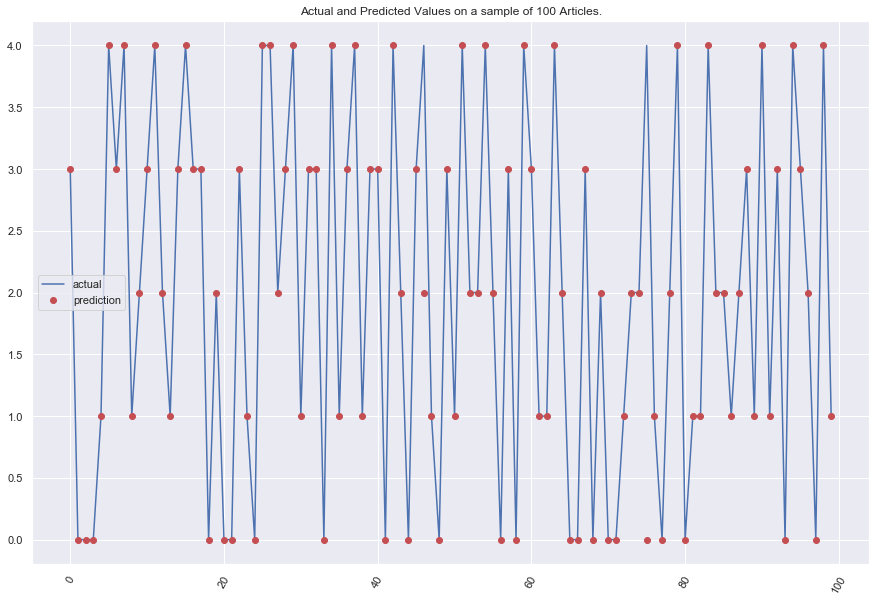

In [16]:
RandomF(bow_xtrain, Train_Y, bow_xtest, Test_Y)

In [17]:
def NaiveFun(trainX , trainY, testX, testY):
    Naive = naive_bayes.MultinomialNB()
    Naive.fit(trainX, trainY)

    predictions_NB = Naive.predict(testX)

    print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, testY)*100)
    print("SVM Accuracy Score -> ",accuracy_score(predictions_NB, testY)*100)
#     print(classification_report(testY, predictions_NB))
    
    ScoringFunc(Naive, trainX, trainY, testX, testY)

Naive Bayes on Tfidf.

In [18]:
NaiveFun(Train_X_Tfidf, Train_Y, Test_X_Tfidf, Test_Y)

Naive Bayes Accuracy Score ->  94.83146067415731
SVM Accuracy Score ->  94.83146067415731

10-fold Cross Validation Score:
fit_time [0.00598669 0.00398922 0.00299025 0.0039618  0.00199533 0.00401664
 0.0029943  0.0030477  0.00299168 0.00299287] 

score_time [0.00298858 0.00199485 0.00199461 0.00199485 0.00199389 0.00099707
 0.00199246 0.00196528 0.00196791 0.00196838] 

test_accuracy [0.8988764  0.93820225 0.90449438 0.8988764  0.93820225 0.95505618
 0.93258427 0.93258427 0.93820225 0.96045198] 

train_accuracy [0.96252342 0.95877577 0.96064959 0.9612742  0.95752655 0.96252342
 0.95815116 0.96189881 0.96064959 0.96129838] 

test_precision [0.89523765 0.93861581 0.90607797 0.9046906  0.94504505 0.96173957
 0.94360621 0.9424025  0.94457814 0.95850966] 

train_precision [0.96487171 0.96089408 0.96293222 0.96298119 0.95990525 0.96411494
 0.95985464 0.96325514 0.96251762 0.96323468] 

test_recall [0.8955916  0.92912296 0.90253968 0.89151101 0.9378053  0.95220863
 0.91709957 0.91797884 0.932

Naive Bayes on BoW.

In [19]:
NaiveFun(bow_xtrain, Train_Y, bow_xtest, Test_Y)

Naive Bayes Accuracy Score ->  97.75280898876404
SVM Accuracy Score ->  97.75280898876404

10-fold Cross Validation Score:
fit_time [0.01495385 0.01397395 0.0099721  0.0140152  0.00997257 0.01396298
 0.0119679  0.009974   0.01196218 0.00997329] 

score_time [0.00399041 0.00500631 0.00398993 0.00393677 0.00498652 0.00498724
 0.00199389 0.00399065 0.00299668 0.00202227] 

test_accuracy [0.94382022 0.97191011 0.94382022 0.96067416 0.98314607 0.98876404
 0.98314607 0.98314607 0.97752809 0.96610169] 

train_accuracy [0.99500312 0.99312929 0.99250468 0.99437851 0.99188007 0.99500312
 0.99250468 0.99312929 0.99250468 0.99313358] 

test_precision [0.93455052 0.96727246 0.94026132 0.95884398 0.98428571 0.98947368
 0.98530997 0.97985714 0.97714286 0.96344538] 

train_precision [0.99443447 0.99233073 0.99155044 0.99367091 0.99094263 0.99439303
 0.99165496 0.99233019 0.9915957  0.99235977] 

test_recall [0.94976527 0.96804946 0.94009921 0.96427159 0.98301587 0.98673684
 0.97992008 0.98245455 0.977

KNN Implementation according to https://medium.com/analytics-vidhya/implementing-k-nearest-neighbours-knn-without-using-scikit-learn-3905b4decc3c.

In [20]:
class KNN:
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        self.Train_X = X
        self.Train_Y = y
        
    def distance(self, X1, X2):
        distance = scipy.spatial.distance.euclidean(X1, X2)
    
    def predict(self, Test_X):
        final_output = []
        for i in range(len(Test_X)):
            d = []
            votes = []
            for j in range(len(self.Train_X)):
                dist = scipy.spatial.distance.euclidean(self.Train_X[j] , Test_X[i])
                d.append([dist, j])
            d.sort()
            d = d[0:self.k]
            for d, j in d:
                votes.append(self.Train_Y[j])
            ans = Counter(votes).most_common(1)[0][0]
            final_output.append(ans)    
        return final_output
    
    def score(self, Test_X, Test_Y):
        predictions = self.predict(Test_X)
        return (predictions == Test_Y).sum() / len(Test_Y)

In [21]:
def ImplKNN(Train_X, Test_X, Train_Y, Test_Y, N):
    
    knn_Train_X = Train_X.toarray()
    knn_Test_X = Test_X.toarray()

    clf = KNN(N)
    clf.fit(knn_Train_X, Train_Y)
    prediction = clf.predict(knn_Test_X)

    error = []
    for i in range(1, 4):
        knn = KNN(i)
        knn.fit(knn_Train_X, Train_Y)
        pred_i = knn.predict(knn_Test_X)
        error.append(np.mean(pred_i != Test_Y))

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 4), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')
    plt.xlabel('K Value')
    plt.ylabel('Mean Error')
    
#     ScoringFunc(clf, Train_X, Train_Y)
    print("KNN Accuracy Score -> ",accuracy_score(prediction, Test_Y)*100)
    print("KNN Recall Score -> ",recall_score(prediction, Test_Y, average='macro')*100)
    print("KNN Precision Score -> ",precision_score(prediction, Test_Y, average='macro')*100)
    print("KNN F-Measure Score -> ",f1_score(prediction, Test_Y, average='macro')*100)
#     print(classification_report(Test_Y, prediction))

KNN on Tfidf.

KNN Accuracy Score ->  91.91011235955057
KNN Recall Score ->  92.25777756874247
KNN Precision Score ->  91.8638703714538
KNN F-Measure Score ->  91.95173828628634


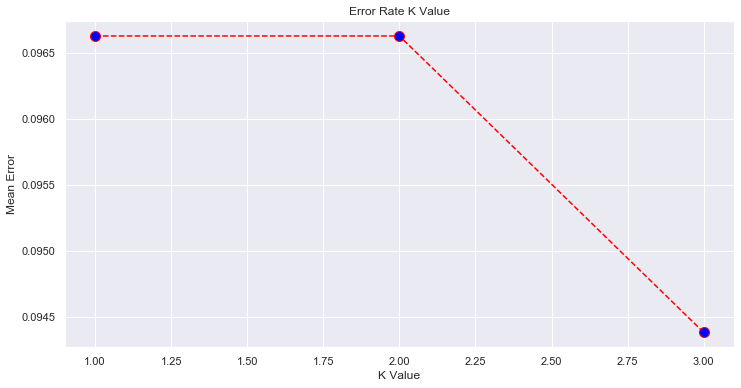

In [22]:
ImplKNN(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, 5)

KNN on BoW.

KNN Accuracy Score ->  77.75280898876404
KNN Recall Score ->  80.51572222778306
KNN Precision Score ->  77.43704931458787
KNN F-Measure Score ->  77.49150862146551


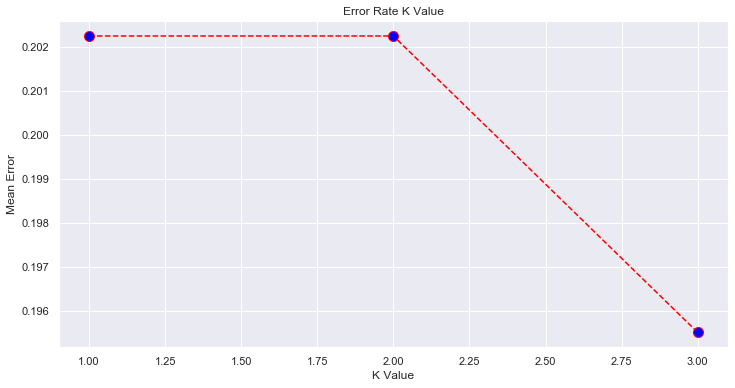

In [23]:
ImplKNN(bow_xtrain, bow_xtest, Train_Y, Test_Y, 5)

## Ερώτημα 3

Βελτίωση του SVM classification.

In [24]:
lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stemmer = nltk.stem.porter.PorterStemmer()

stop_words = nltk.corpus.stopwords.words('english')
stop_words.append(["us"])

def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

def remove_stopwords(text):
    words = [w for w in text if w not in stop_words]
    return words

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i for i in text)]
    return lem_text

def word_stemmer(text):
    stem_text = " ".join([stemmer.stem(i) for i in text])
    return stem_text

dfImp = df
dfImp.loc[:,"Content"] = dfImp.Content.apply(lambda x: remove_punctuation(x))
# dfImp.loc[:,"Content"] = dfImp.Content.apply(lambda x : " ".join(re.findall('[\w]+',x))) # NOT GOOD
dfImp.loc[:,"Content"] = dfImp.Content.apply(lambda x: tokenizer.tokenize(x.lower()))
dfImp.loc[:,"Content"] = dfImp.Content.apply(lambda x: remove_stopwords(x))
# dfImp.loc[:,"Content"] = dfImp.Content.apply(lambda x: word_lemmatizer(x)) #ERROR
dfImp.loc[:,"Content"] = dfImp.Content.apply(lambda x: word_stemmer(x))

Train_X2, Test_X2, Train_Y2, Test_Y2 = train_test_split(dfImp["Content"], dfImp['Label'], test_size=0.2)
Encoder = LabelEncoder()
Train_Y2 = Encoder.fit_transform(Train_Y2)
Test_Y2 = Encoder.fit_transform(Test_Y2)
Tfidf_vect2 = TfidfVectorizer(stop_words = 'english')
Tfidf_vect2.fit(dfImp["Content"])
Train_X_Tfidf2 = Tfidf_vect2.transform(Train_X2)
Test_X_Tfidf2 = Tfidf_vect2.transform(Test_X2)

SVMex(Train_X_Tfidf2, Train_Y2, Test_X_Tfidf2, Test_Y2, dfImp['Label'])

SVM Accuracy Score ->  97.97752808988764
SVM Recall Score ->  98.00525206263929
SVM Precision Score ->  98.00206877161966
SVM F-Measure Score ->  97.99237403027792
Accuracy: 0.98 (+/- 0.01)

10-fold Cross Validation Score:
fit_time [16.46737242 16.19950819 16.16199279 16.38531446 16.70800328 16.21451688
 16.79589915 16.39095664 16.51472068 16.17178702] 

score_time [0.20515466 0.19997144 0.2049191  0.20674181 0.21043611 0.20877743
 0.20502043 0.20445442 0.21272588 0.20254421] 

test_accuracy [0.96629213 0.97191011 0.98314607 0.99438202 0.97752809 0.99438202
 0.97191011 0.98314607 0.98314607 0.97175141] 

train_accuracy [0.99937539 0.99937539 0.99937539 0.99937539 0.99937539 0.99937539
 0.99937539 1.         0.99937539 0.99937578] 

test_precision [0.96680672 0.97483193 0.98205128 0.99333333 0.97766123 0.99487179
 0.97215107 0.98232353 0.98078431 0.97197929] 

train_precision [0.99933555 0.99936102 0.99935691 0.99933333 0.9993311  0.99932432
 0.99933993 1.         0.99933993 0.99933555]

## Ερώτημα 4

In [25]:
Label_Titles = df["Category"].unique()
Contents = df["Content"]
Labels = df['Label']

Tfidf_vect = TfidfVectorizer(min_df = 5, max_df = 0.95, max_features = 8000, stop_words = 'english')
Tfidf_vect.fit(Contents)
Contents_Tfidf = Tfidf_vect.transform(Contents)

Encoder = LabelEncoder()
Labels = Encoder.fit_transform(Labels)

train_to_list = np.array(Contents.values.tolist())
BoWvect = CountVectorizer()
bow_Contents = BoWvect.fit_transform(train_to_list)

## Plot Functions.

In [26]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
def plot_pca(data, labels, kmeans, Train_Y, indicator):
    pca = PCA(n_components=2).fit_transform(data.todense())
    fitted = kmeans.fit(pca)
    centroids = kmeans.cluster_centers_
    prediction = kmeans.predict(pca)

    fig = plt.figure(figsize=[15,10])
    _ = plt.scatter(pca[:,0], pca[:,1], alpha=0.5, edgecolor='k', c=labels, cmap='rainbow')
    _ = plt.title('PCA Cluster Plot with Centroids. Real Categories.')
    _ = plt.colorbar()
    _ = plt.scatter(centroids[:, 0], centroids[:, 1], color='yellow', s=300, marker='*')
    
    if(indicator==True):
        cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
        cluster_names = {0: Label_Titles[0], 1: Label_Titles[1], 2: Label_Titles[2], 3: Label_Titles[3], 4: Label_Titles[4]}
        clusters = kmeans.labels_.tolist()
        dfNEW = pd.DataFrame(dict(x=pca[:,0], y=pca[:,1], Clusters=clusters, title=titles, label=Labels)) 
        groups = dfNEW.groupby('label')
        fig, ax = plt.subplots(figsize=(17, 9)) # set size
        ax.margins(0.05)
        for name, group in groups:
            ax.plot(group.x, group.y, marker='o', label=cluster_names[name], color=cluster_colors[name], alpha=0.5, linestyle='')
            ax.set_aspect('auto')
            ax.tick_params(\
                axis= 'x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom='off',      # ticks along the bottom edge are off
                top='off',         # ticks along the top edge are off
                labelbottom='off')
            ax.tick_params(\
                axis= 'y',         # changes apply to the y-axis
                which='both',      # both major and minor ticks are affected
                left='off',      # ticks along the bottom edge are off
                top='off',         # ticks along the top edge are off
                labelleft='off')
        ax.legend(numpoints=1)  #show legend with only 1 point
        plt.show()

    fig = plt.figure(figsize=[15,10])
    _ = plt.title('K-Means Clusters.')
    _ = plt.scatter(pca[:,0], pca[:,1], c=prediction, cmap='rainbow', alpha=0.5, edgecolor='k')
    centers = fitted.cluster_centers_
    _ = plt.scatter(centers[:, 0], centers[:, 1], s=300, alpha=0.6, marker='*', color='black')

def plotICA(data, labels, kmeans, Train_Y, indicator):
    ica = FastICA(n_components=3).fit_transform(data.todense())
    fitted = kmeans.fit(ica)
    centroids = kmeans.cluster_centers_
    prediction = kmeans.predict(ica)
    
    fig = plt.figure(figsize=[15,10])
    _ = plt.scatter(ica[:,0], ica[:,1], alpha=0.5, edgecolor='k', c=labels, cmap='rainbow')
    _ = plt.title('ICA Cluster Plot with Centroids. Real Categories.')
    _ = plt.colorbar()
    _ = plt.scatter(centroids[:, 0], centroids[:, 1], color='black', s=300, marker='*')

    if(indicator==True):
        cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
        cluster_names = {0: Label_Titles[0], 1: Label_Titles[1], 2: Label_Titles[2], 3: Label_Titles[3], 4: Label_Titles[4]}
        clusters = kmeans.labels_.tolist()
        dfNEW = pd.DataFrame(dict(x=ica[:,0], y=ica[:,1], Clusters=clusters, title=titles, label=Labels)) 
        groups = dfNEW.groupby('label')
        fig, ax = plt.subplots(figsize=(17, 9)) # set size
        ax.margins(0.05)
        for name, group in groups:
            ax.plot(group.x, group.y, marker='o', label=cluster_names[name], color=cluster_colors[name], alpha=0.5, linestyle='')
            ax.set_aspect('auto')
            ax.tick_params(\
                axis= 'x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom='off',      # ticks along the bottom edge are off
                top='off',         # ticks along the top edge are off
                labelbottom='off')
            ax.tick_params(\
                axis= 'y',         # changes apply to the y-axis
                which='both',      # both major and minor ticks are affected
                left='off',      # ticks along the bottom edge are off
                top='off',         # ticks along the top edge are off
                labelleft='off')
        ax.legend(numpoints=1)  #show legend with only 1 point
        plt.show()

    fig = plt.figure(figsize=[15,10])
    _ = plt.title('K-Means Clusters with Centroids.')
    _ = plt.scatter(ica[:,0], ica[:,1], c=prediction, cmap='rainbow', alpha=0.5, edgecolor='k')
    centers = fitted.cluster_centers_
    _ = plt.scatter(centers[:, 0], centers[:, 1], s=300, alpha=0.6, marker='*', color='yellow')
    
def plotSVD(data, labels, kmeans, Train_Y, indicator):
    svd = TruncatedSVD(n_components=5, n_iter=7).fit_transform(data.todense())
    fitted = kmeans.fit(svd)
    centroids = kmeans.cluster_centers_
    prediction = kmeans.predict(svd)
    
    fig = plt.figure(figsize=[15,10])
    _ = plt.scatter(svd[:,0], svd[:,1], alpha=0.5, edgecolor='k', c=labels, cmap='rainbow')
    _ = plt.title('SVD Cluster Plot with Centroids. Real Categories.')
    _ = plt.colorbar()
    _ = plt.scatter(centroids[:, 0], centroids[:, 1], color='black', s=300, marker='*')

    if(indicator==True):
        cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
        cluster_names = {0: Label_Titles[0], 1: Label_Titles[1], 2: Label_Titles[2], 3: Label_Titles[3], 4: Label_Titles[4]}
        clusters = kmeans.labels_.tolist()
        dfNEW = pd.DataFrame(dict(x=svd[:,0], y=svd[:,1], Clusters=clusters, title=titles, label=Labels)) 
        groups = dfNEW.groupby('label')
        fig, ax = plt.subplots(figsize=(17, 9)) # set size
        ax.margins(0.05)
        for name, group in groups:
            ax.plot(group.x, group.y, marker='o', label=cluster_names[name], color=cluster_colors[name], alpha=0.5, linestyle='')
            ax.set_aspect('auto')
            ax.tick_params(\
                axis= 'x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom='off',      # ticks along the bottom edge are off
                top='off',         # ticks along the top edge are off
                labelbottom='off')
            ax.tick_params(\
                axis= 'y',         # changes apply to the y-axis
                which='both',      # both major and minor ticks are affected
                left='off',      # ticks along the bottom edge are off
                top='off',         # ticks along the top edge are off
                labelleft='off')
        ax.legend(numpoints=1)  #show legend with only 1 point
        plt.show()

    fig = plt.figure(figsize=[15,10])
    _ = plt.title('K-Means Clusters with Centroids.')
    _ = plt.scatter(svd[:,0], svd[:,1], c=prediction, cmap='rainbow', alpha=0.5, edgecolor='k')
    centers = fitted.cluster_centers_
    _ = plt.scatter(centers[:, 0], centers[:, 1], s=300, alpha=0.6, marker='*', color='yellow')
    
def Clustering(data, Train_Y):
    find_optimal_clusters(data, 10)
    kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=600, n_init=10, random_state=0, algorithm='auto')
    plot_pca(data, kmeans.fit_predict(data), kmeans, Train_Y, True)
    plotICA(data, kmeans.fit_predict(data), kmeans, Train_Y, True)
    plotSVD(data, kmeans.fit_predict(data), kmeans, Train_Y, True)

def Clustering2(data):
    find_optimal_clusters(data, 10)
    kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=600, n_init=10, random_state=0, algorithm='auto')
    kmeans.fit(data)
    labels = kmeans.labels_
    plot_pca(sparse.csr_matrix(data), kmeans.fit_predict(data), kmeans, labels, False)
    plotICA(sparse.csr_matrix(data), kmeans.fit_predict(data), kmeans, labels, False)
    plotSVD(sparse.csr_matrix(data), kmeans.fit_predict(data), kmeans, labels, False)

## Clustering στον tf-idf μετασχηματισμό των counts.

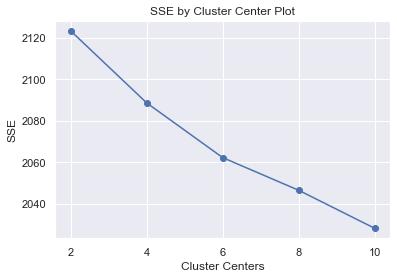

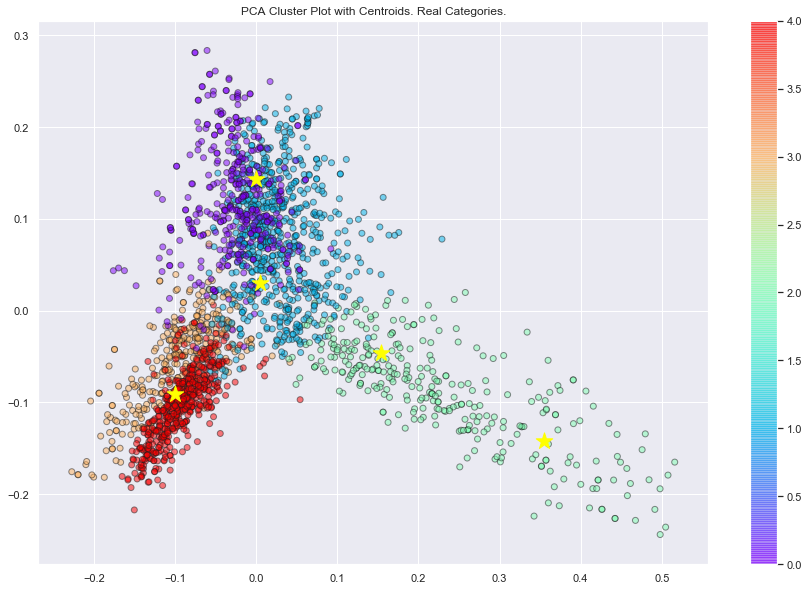

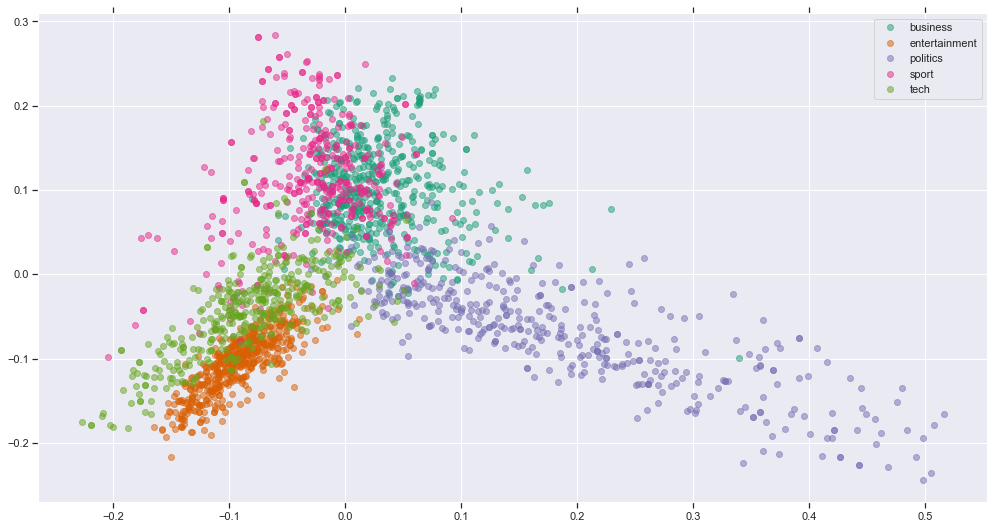

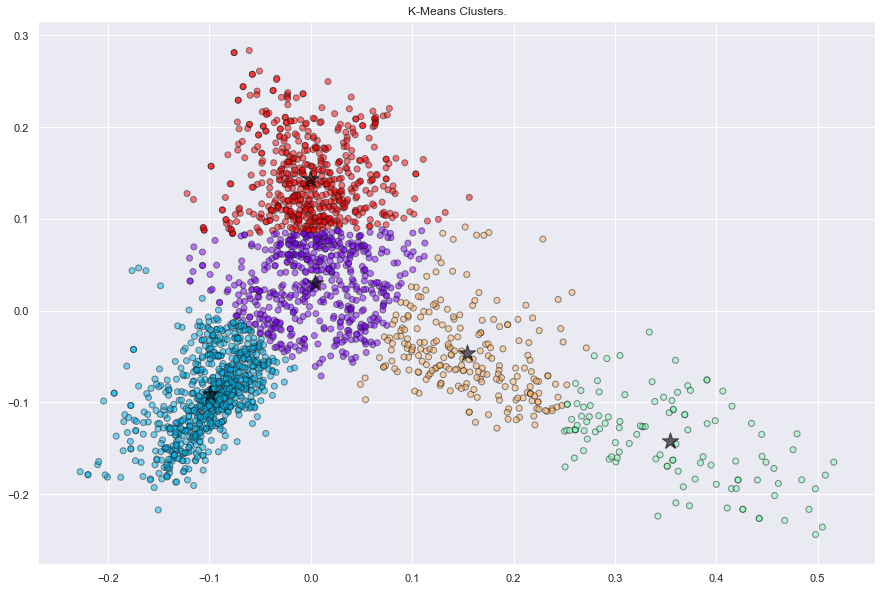

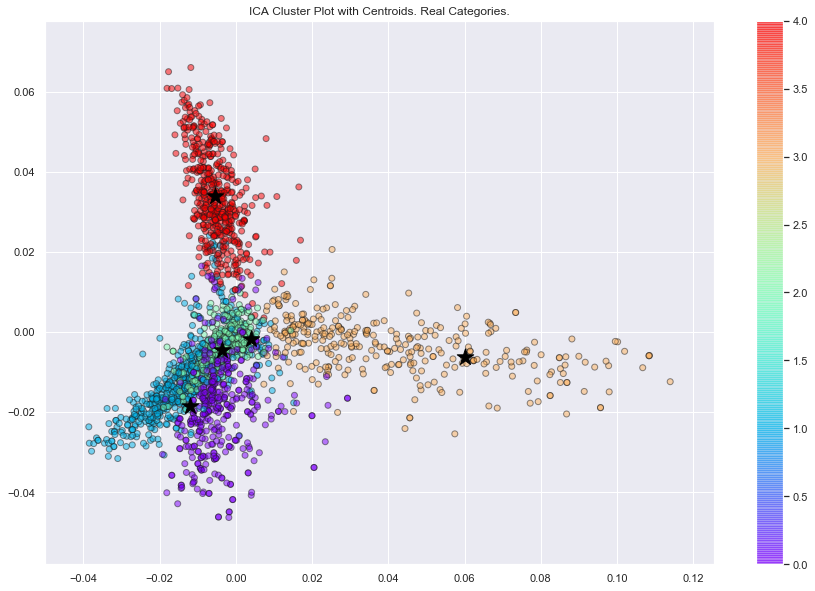

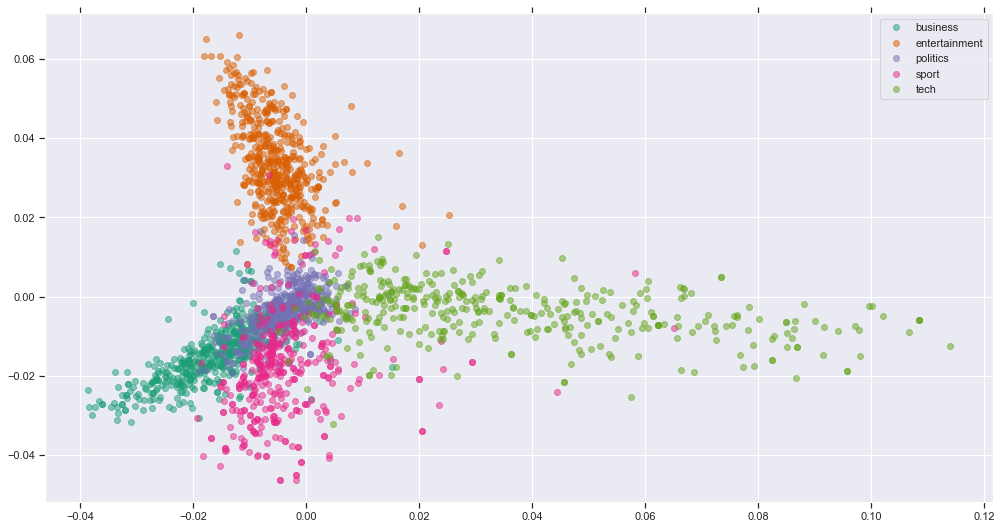

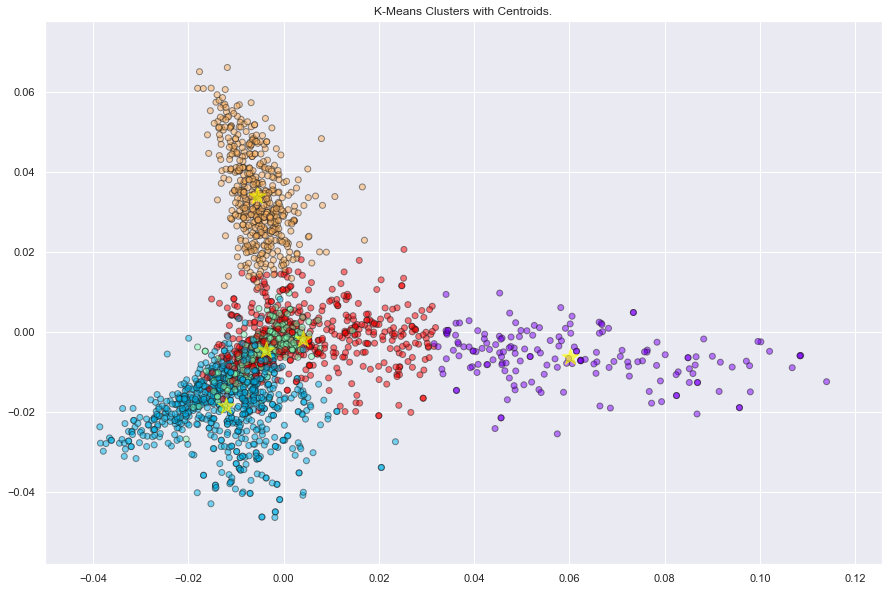

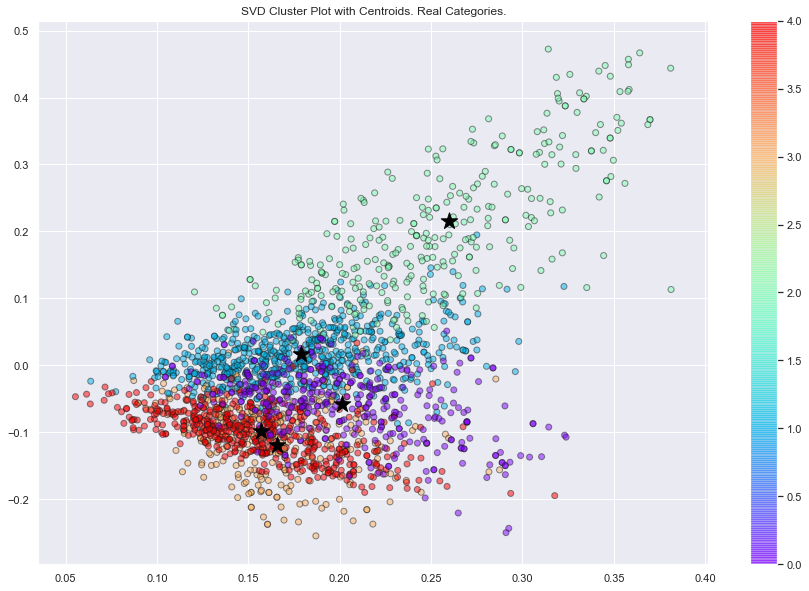

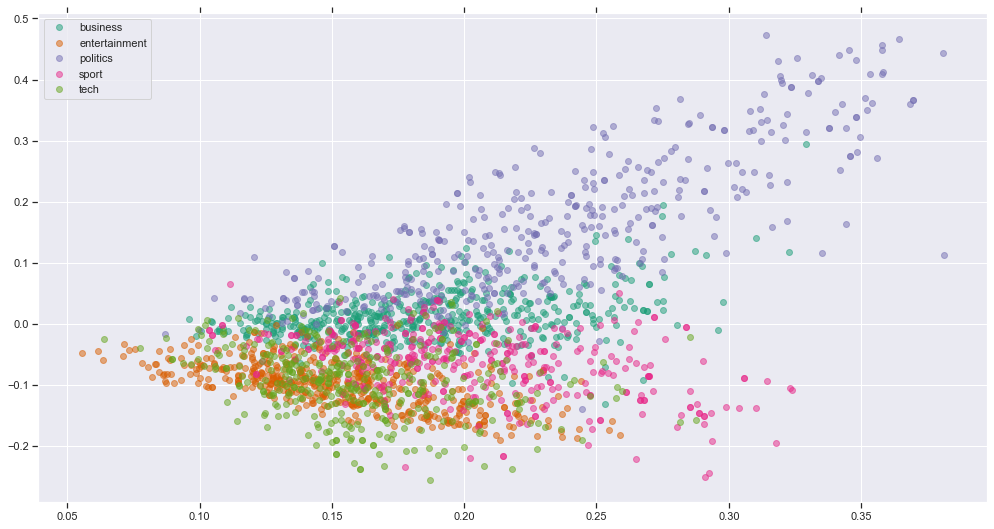

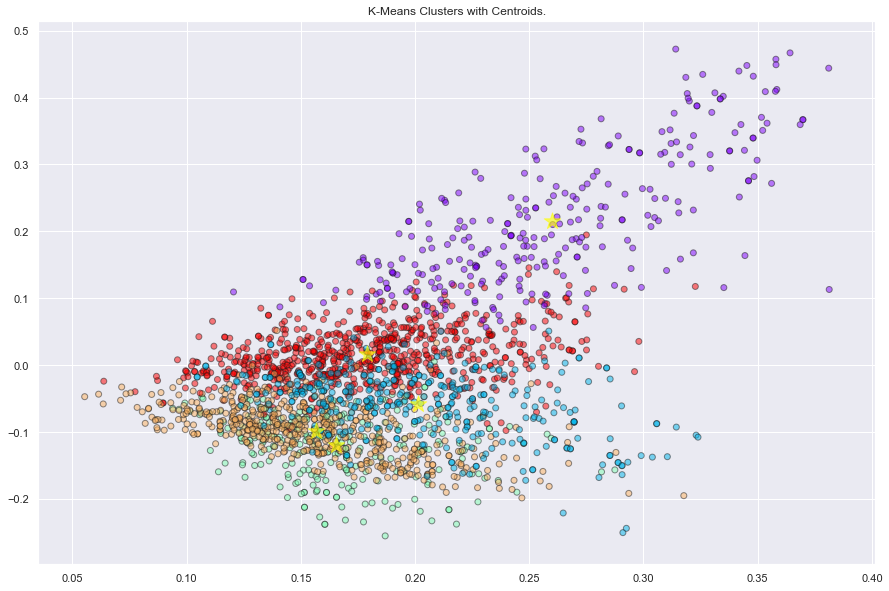

In [27]:
Clustering(Contents_Tfidf, Labels)

## Clustering στην BoW αναπαράσταση.

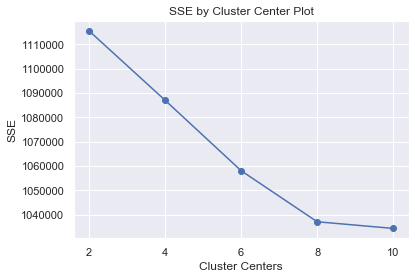

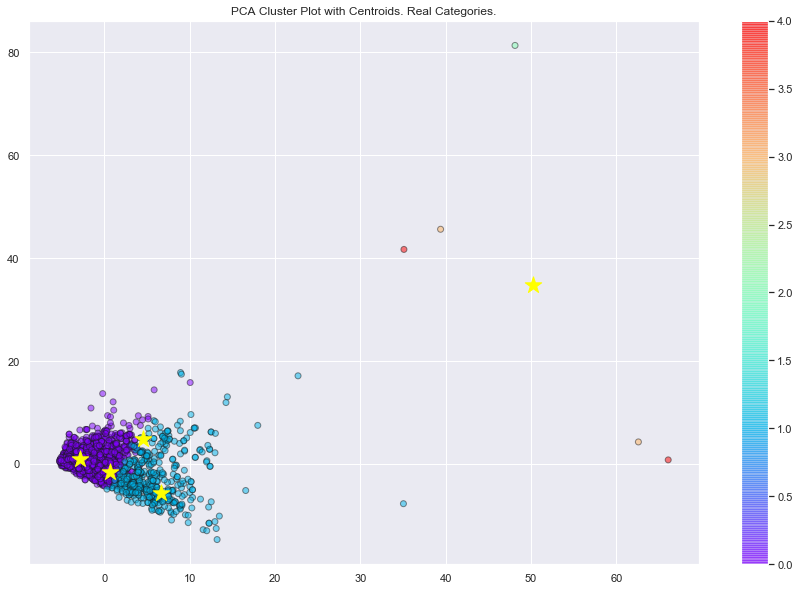

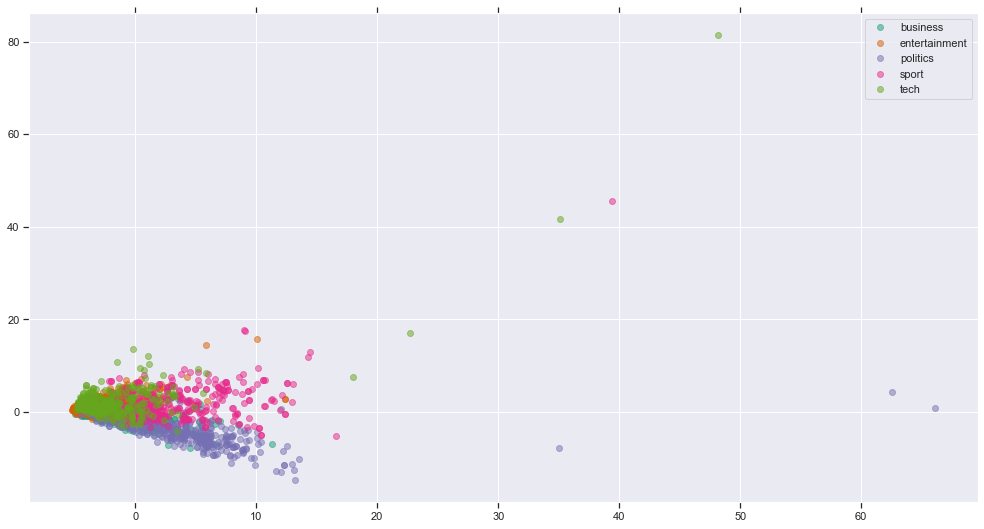

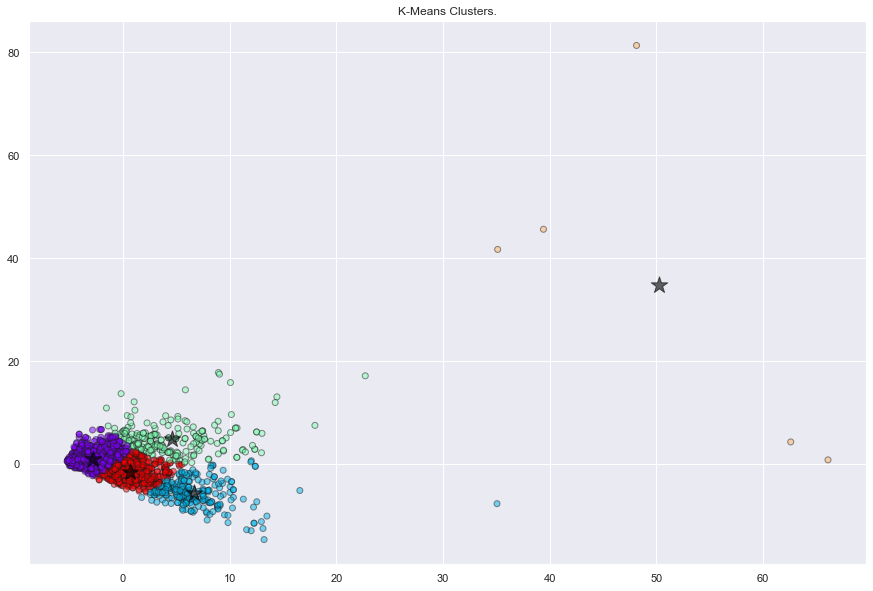

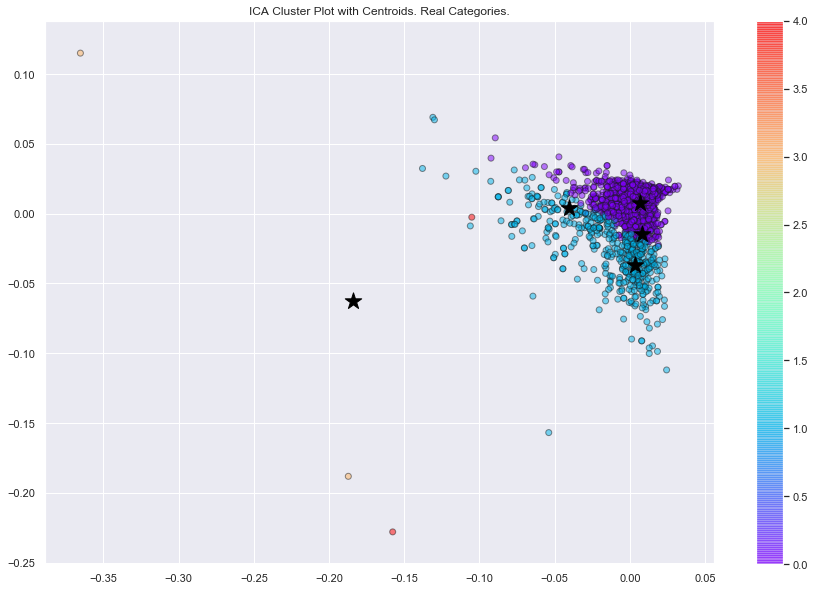

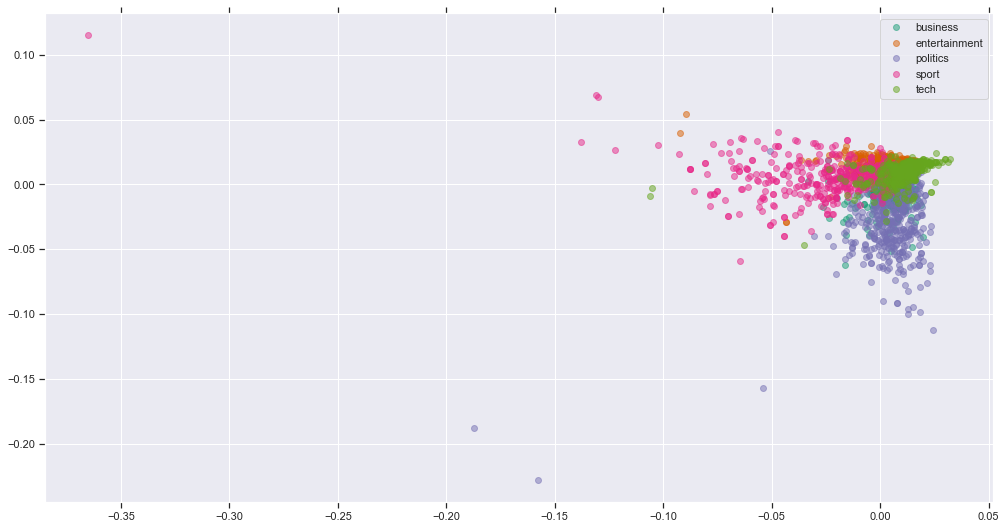

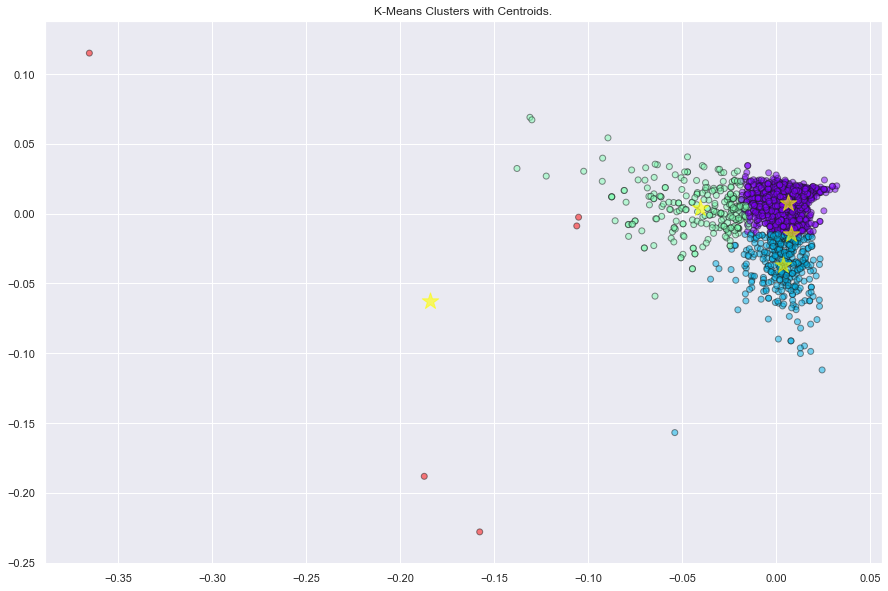

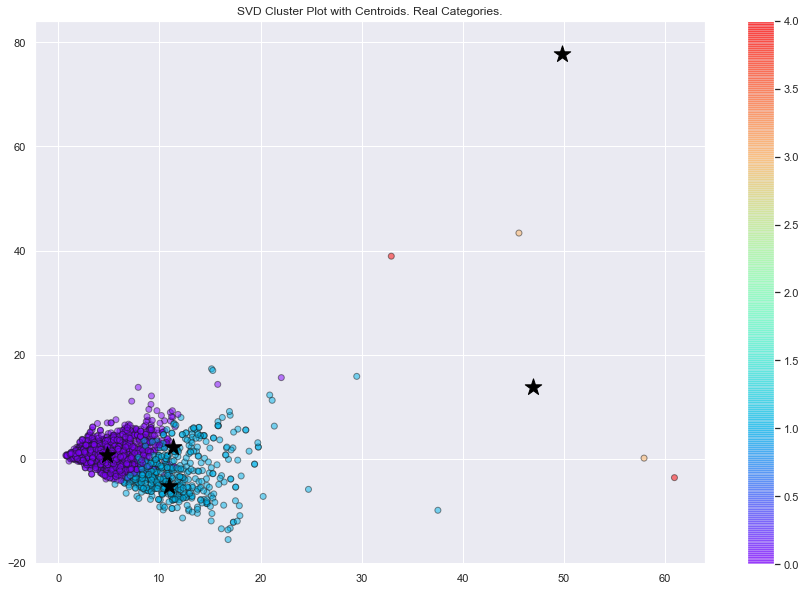

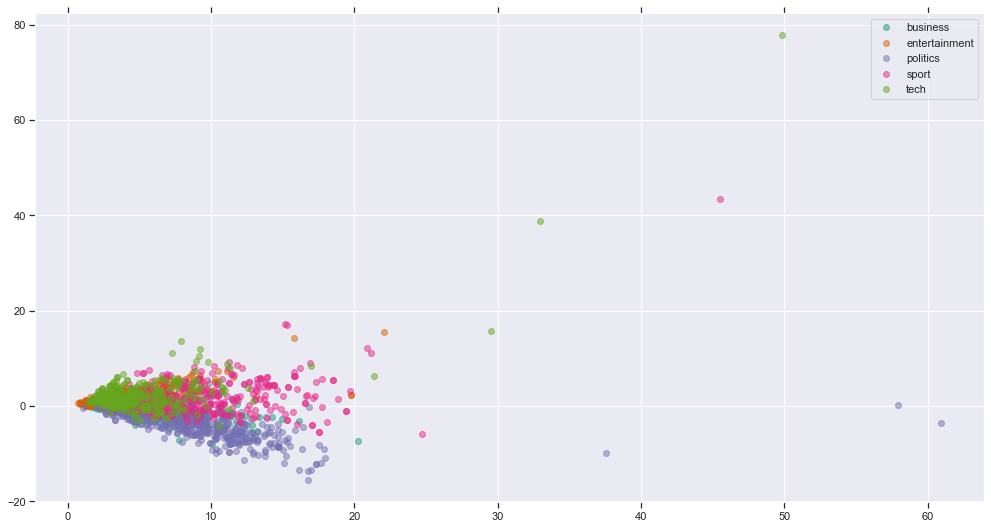

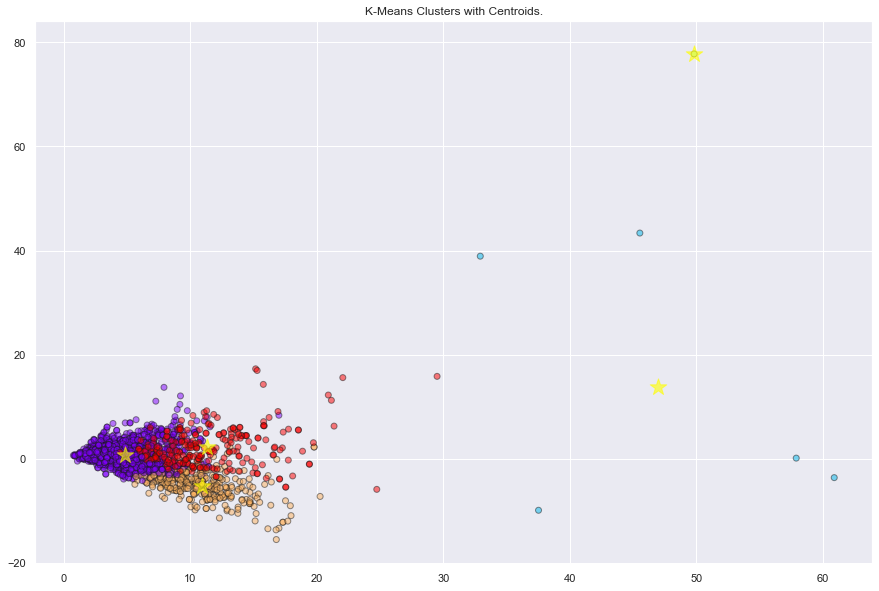

In [28]:
Clustering(bow_Contents, Labels)

# Pipeline Transform for CountVectorizer and TfidfTransformer.

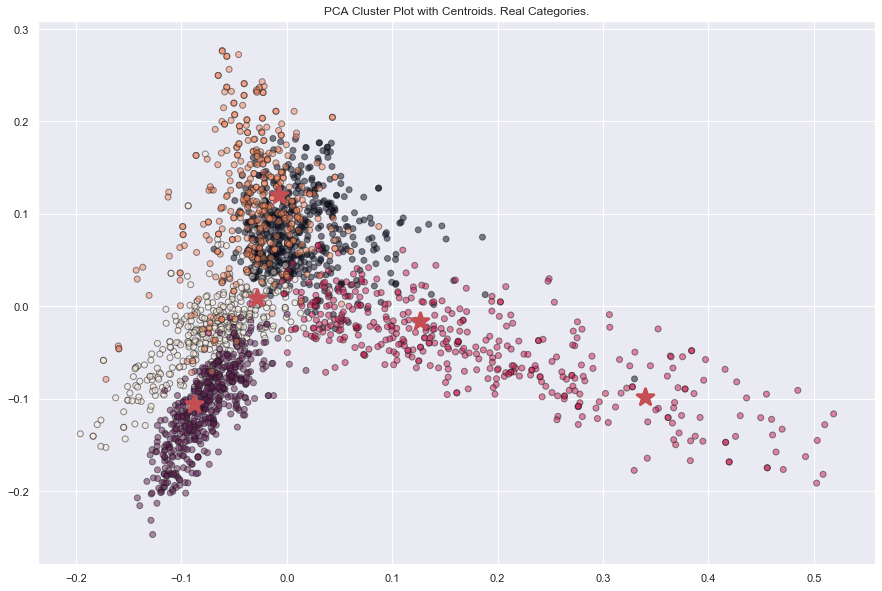

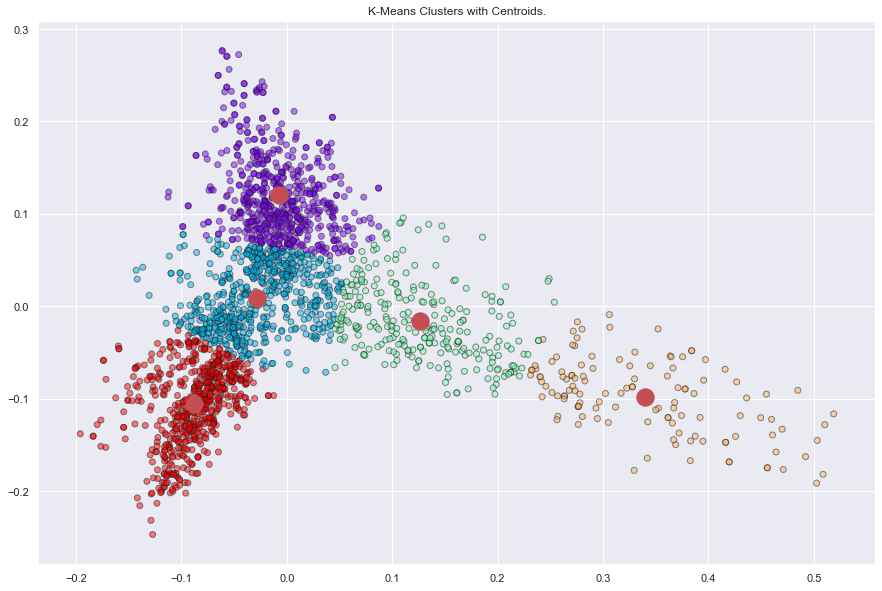

In [29]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

PipelineTransform = pipeline.fit_transform(Contents).todense()

pca = PCA(n_components=2).fit(PipelineTransform)
data2D = pca.transform(PipelineTransform)

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=600, n_init=10, random_state=0, algorithm='auto')
kmeans.fit(data2D)

labels = kmeans.predict(data2D)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=[15,10])
_ = plt.scatter(data2D[:,0], data2D[:,1], alpha=0.5, edgecolor='k', c=Labels)
_ = plt.title('PCA Cluster Plot with Centroids. Real Categories.')
for idx, centroid in enumerate(centroids):
    _ = plt.scatter(*centroid, color='r', s=300, marker='*', linewidths=3)
    
fig = plt.figure(figsize=[15,10])
_ = plt.scatter(data2D[:,0], data2D[:,1], alpha=0.5, edgecolor='k', c=labels, cmap='rainbow')
_ = plt.title('K-Means Clusters with Centroids.')
for idx, centroid in enumerate(centroids):
    _ = plt.scatter(*centroid, color='r', s=300)

## Clustering στον πίνακα document-embeddings.

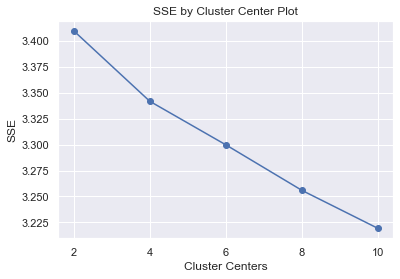

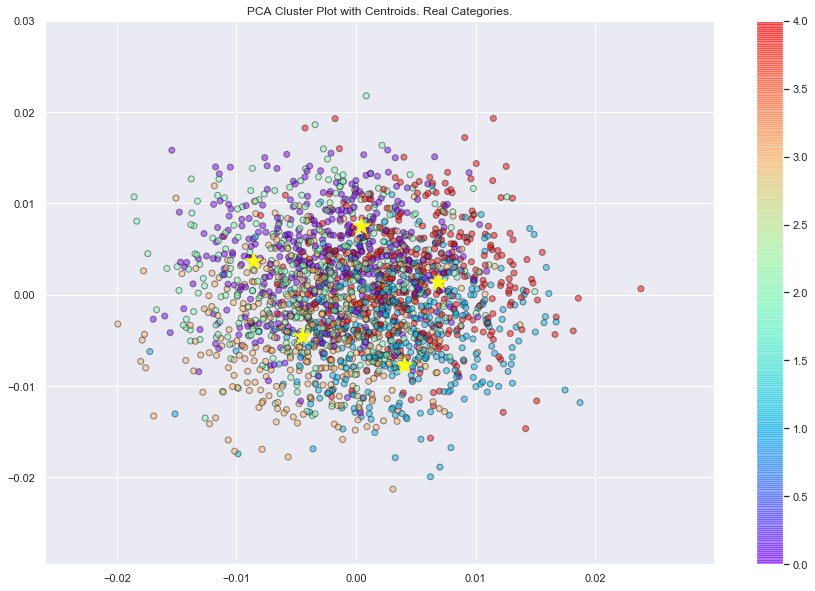

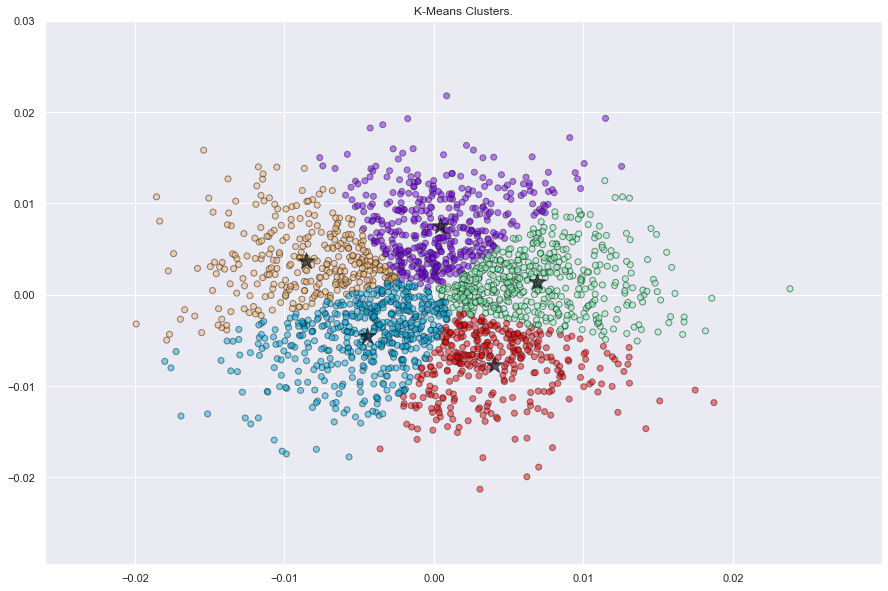

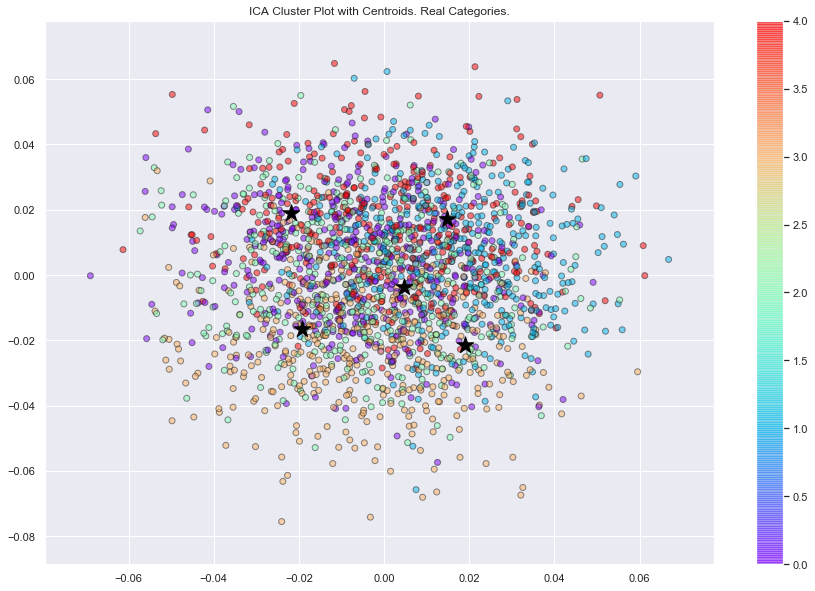

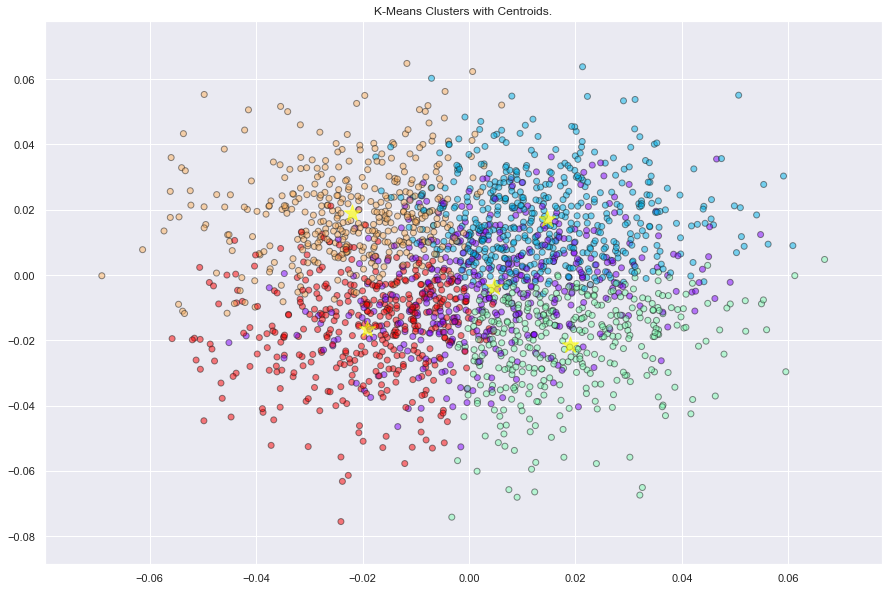

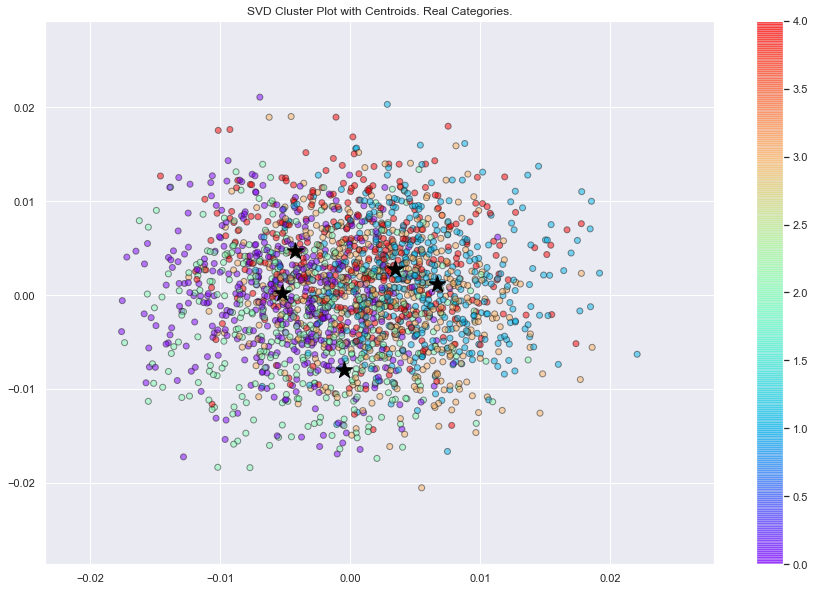

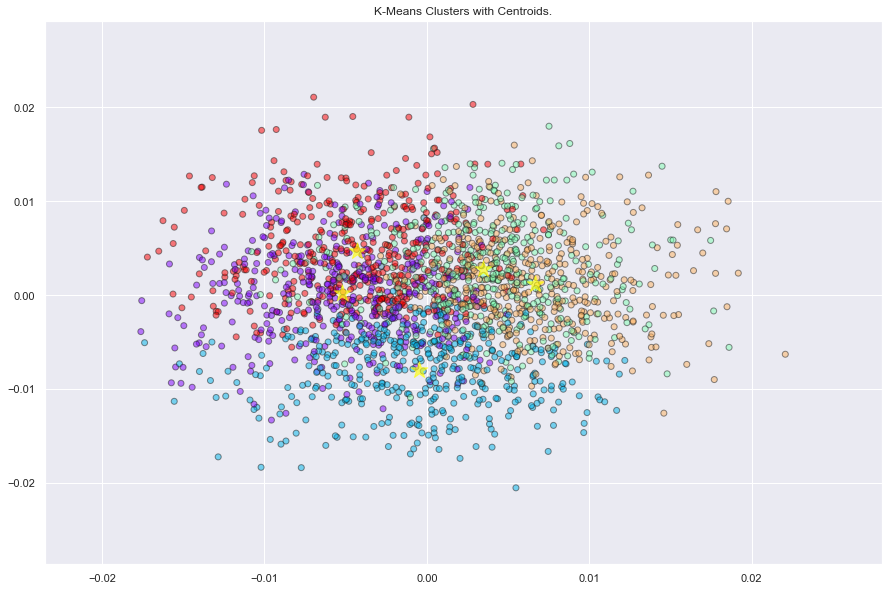

In [30]:
sent = [row.split(',') for row in Contents]
model = Word2Vec(sent, min_count=1,size= 50,workers=3, window =3, sg = 1)
X = model[model.wv.vocab]

Clustering2(X)